# Intraday Opening Gap Strategy

## Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

## Load Data

In [2]:
FSTXdf = pd.read_csv('data/FSTX_history.csv', skiprows=1)
FSTXdf.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
FSTXdf['Date'] = pd.to_datetime(FSTXdf['Date'], errors='coerce')
FSTXdf['Open'] = pd.to_numeric(FSTXdf['Open'], errors='coerce')
FSTXdf['High'] = pd.to_numeric(FSTXdf['High'], errors='coerce')
FSTXdf['Low'] = pd.to_numeric(FSTXdf['Low'], errors='coerce')
FSTXdf['Close'] = pd.to_numeric(FSTXdf['Close'], errors='coerce')

FSTXdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-04-02,4177.310059,4191.759766,4163.770020,4189.549805,4189.549805,0.0
1,2007-04-03,4199.540039,4248.069824,4199.540039,4246.299805,4246.299805,0.0
2,2007-04-04,4252.709961,4261.830078,4242.049805,4261.830078,4261.830078,0.0
3,2007-04-05,4259.979980,4274.169922,4253.790039,4271.540039,4271.540039,0.0
4,2007-04-10,4275.680176,4307.660156,4267.009766,4301.470215,4301.470215,0.0


## Strategy

In [3]:
def calculateReturns(data, lag=1):
    return data.pct_change(periods=lag)

def smartMovingStd(data, window):
    return data.shift(1).rolling(window=window).std()

entryZscore = 0.1

returns = calculateReturns(FSTXdf['Close'])
stdretC2C90d = smartMovingStd(returns, 90)

longs = FSTXdf['Open'] > FSTXdf['High'].shift(1) * (1 + entryZscore * stdretC2C90d)
shorts = FSTXdf['Open'] < FSTXdf['Low'].shift(1) * (1 - entryZscore * stdretC2C90d)

FSTXdf['Positions'] = np.where(longs, 1, np.where(shorts, -1, 0))

C:\Users\Arjun\AppData\Local\Temp\ipykernel_22080\2174158170.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  return data.pct_change(periods=lag)


## Returns, Plotting, Statistics

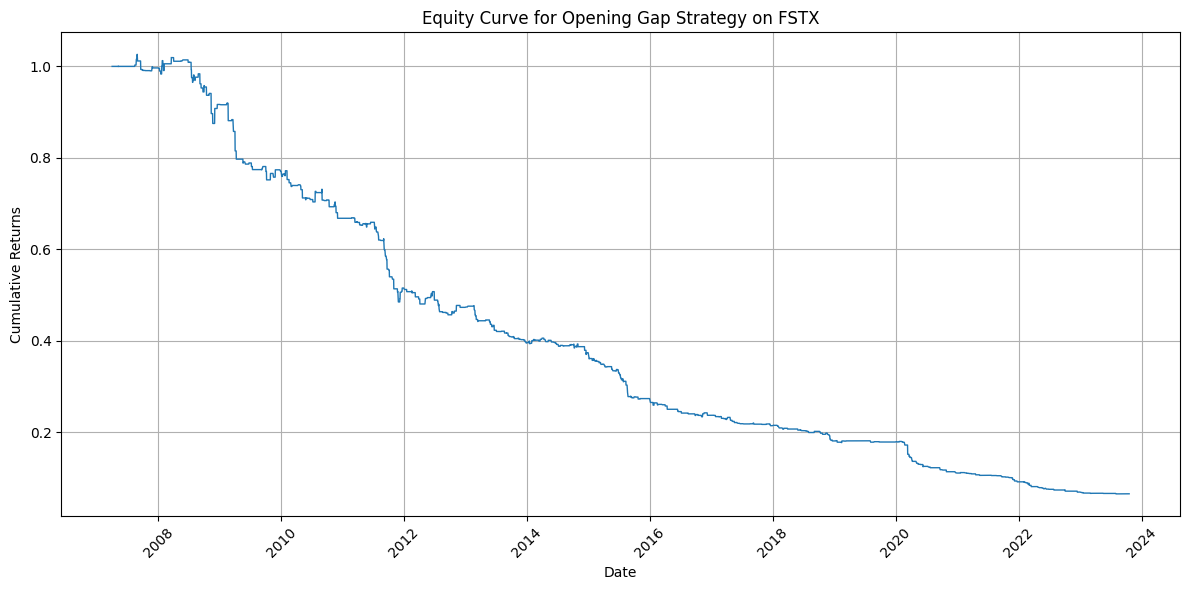

APR: -15.15%
Sharpe Ratio: -2.81


In [4]:
FSTXdf['Strategy_Return'] = FSTXdf['Positions'] * (FSTXdf['Open'] - FSTXdf['Close']) / FSTXdf['Open']
FSTXdf['Cumulative_Returns'] = (1 + FSTXdf['Strategy_Return']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(FSTXdf['Date'], FSTXdf['Cumulative_Returns'], label='Equity Curve', lw=1)
plt.title('Equity Curve for Opening Gap Strategy on FSTX')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# APR
days = (FSTXdf['Date'].iloc[-1] - FSTXdf['Date'].iloc[0]).days
apr = (FSTXdf['Cumulative_Returns'].iloc[-1]) ** (365.0/days) - 1

# Sharpe Ratio
risk_free_rate = 0.053
daily_returns = FSTXdf['Strategy_Return']
sharpe_ratio = (daily_returns.mean() - risk_free_rate/252) / daily_returns.std() * (252 ** 0.5)

print(f"APR: {apr*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")